# Augmented Reality
This is an implementation of augmented reality which uses a book cover as a marker.


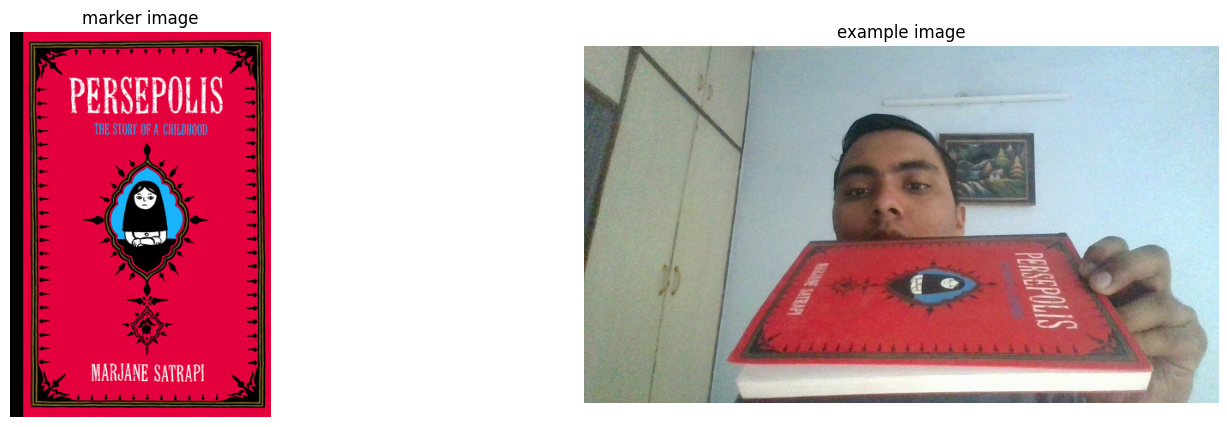

In [61]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the marker image. And display for illustration purpose.
MARKER_IMAGE = cv2.imread('marker.jpg')
MARKER_IMAGE = cv2.cvtColor(MARKER_IMAGE, cv2.COLOR_BGR2RGB)

example_image = cv2.imread('ex1.jpg') # this image is used for displaying examples in this notebook
example_image = cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(MARKER_IMAGE)
plt.title('marker image')

plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(example_image)
plt.title('example image')
plt.show()

# Find the marker in each frame: Feature Detection, Description and Matching

## 1. Feature Detection and Description
Using SIFT algorithm for feature detection and description. https://docs.opencv.org/3.4/da/df5/tutorial_py_sift_intro.html

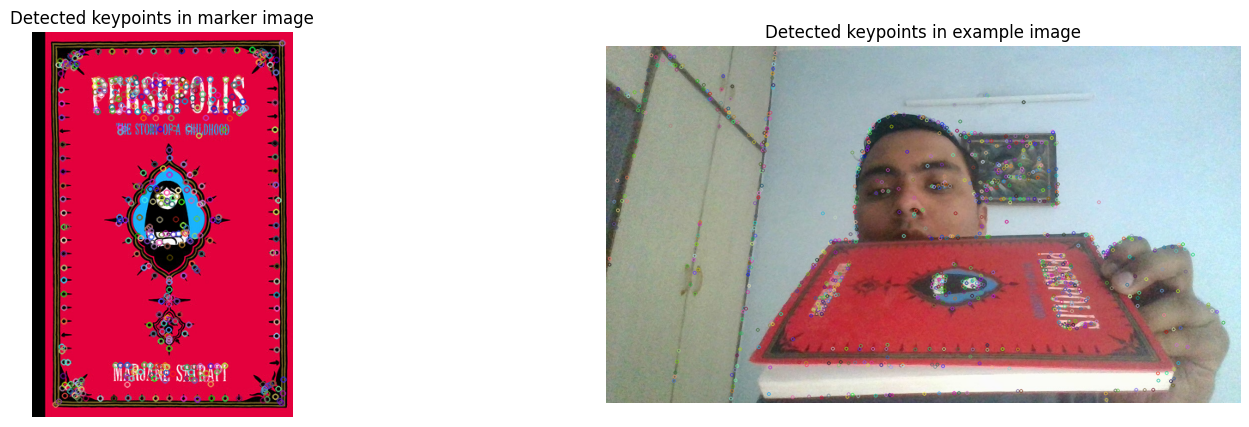

In [62]:
sift = cv2.SIFT_create()


def FEATURE_DETECTION_AND_DESCRIPTION(image):
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors, cv2.drawKeypoints(image, keypoints, image)


MARKER_KP, MARKER_DESC, marker_image_with_key_points = FEATURE_DETECTION_AND_DESCRIPTION(MARKER_IMAGE)
example_kp, example_desc, example_image_with_key_points = FEATURE_DETECTION_AND_DESCRIPTION(example_image)

# plotting the detected keypoints in marker and example image.
plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(marker_image_with_key_points)
plt.title("Detected keypoints in marker image")

plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(example_image_with_key_points)
plt.title("Detected keypoints in example image")
plt.show()

## 2. Feature Matching
Using Brute-Force matching; https://docs.opencv.org/3.4/dc/dc3/tutorial_py_matcher.html.
BFMatcher() uses a distance metric, and thresholding.

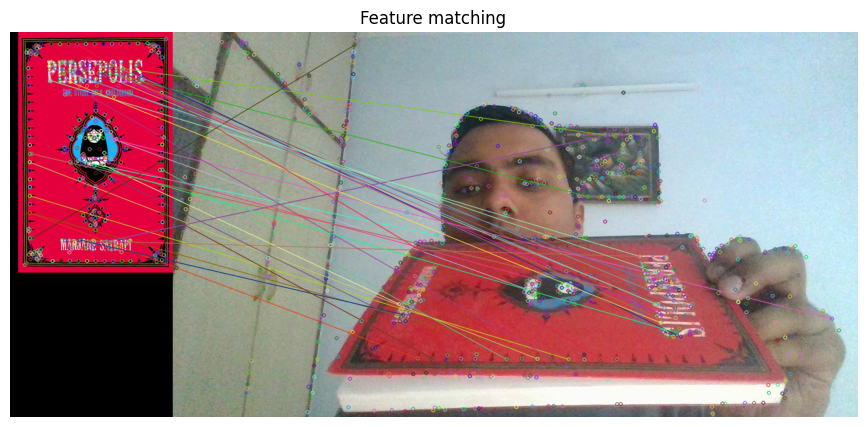

In [63]:
bf  = cv2.BFMatcher(crossCheck = True) # create a brute-force matcher object

def FEATURE_MATCHING(image, image_desc):
    matches = bf.match(MARKER_DESC, image_desc)
    return sorted(matches, key = lambda x: x.distance) # sort the matches in the order of distance.




example_matches = FEATURE_MATCHING(example_image, example_desc) # match features of the example image with the marker image, for illustration.

matched_image_ref = cv2.drawMatches(MARKER_IMAGE, MARKER_KP, example_image, example_kp, example_matches[:40], 0, flags=2)
plt.figure(figsize=(18, 5))
plt.axis('off')
plt.imshow(matched_image_ref)
plt.title('Feature matching')
plt.show() # notice that outliers are also matched.

# Finding Homography matrix
Code adapted from https://docs.opencv.org/3.4/d1/de0/tutorial_py_feature_homography.html.
Using the RANSAC algorithm.

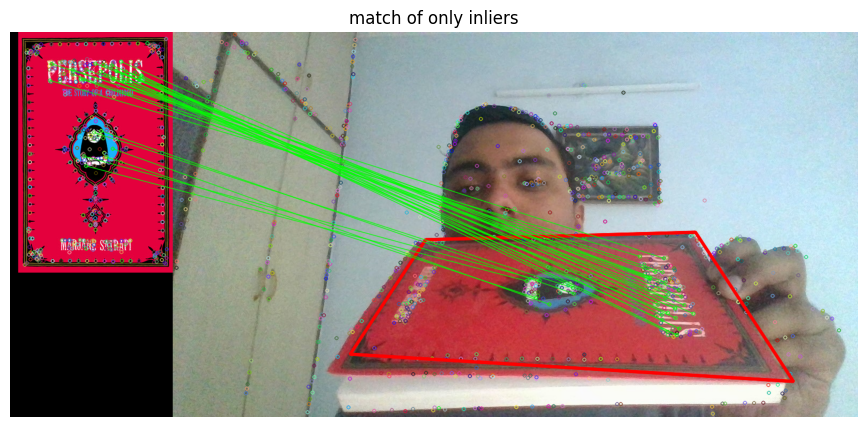

In [72]:
threshold_num_matches = 40 # minimum number of matches required so that further processing can be done.

def HOMOGRAPHY(image, image_kp, image_desc, image_matches):
    if len(image_matches) > threshold_num_matches:
        marker_pts = np.float32([MARKER_KP[m.queryIdx].pt for m in image_matches]).reshape(-1, 1, 2) 
        image_pts = np.float32([image_kp[m.trainIdx].pt for m in image_matches]).reshape(-1, 1, 2)
        
        M, mask = cv2.findHomography(marker_pts, image_pts, cv2.RANSAC, 5.0) # finds the perspective transform of the marker
        matchesMask = mask.ravel().tolist()
        
        h, w, _ = MARKER_IMAGE.shape
        pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2) 
        dst = cv2.perspectiveTransform(pts, M) # From tutorial link above: Needs at least 4 correct points to find transformation.
        
        image = cv2.polylines(image, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)
    else:
        print("Not enough matches found - {}/{}".format(len(matches), threshold_num_matches))
        matchesMask = None
    
    return M, matchesMask



# Finding homography matrix M and inliers for the example image
M, matchesMask = HOMOGRAPHY(example_image, example_kp, example_desc, example_matches)
# draw the inliers for the example image
draw_params = dict(matchColor = (0, 255, 0), singlePointColor = None, matchesMask = matchesMask, # draw only inliers
                   flags = 2)
                   

inlier_matched_image = cv2.drawMatches(MARKER_IMAGE, MARKER_KP, example_image, example_kp, example_matches, None, **draw_params)
plt.figure(figsize=(18, 5))
plt.axis('off')
plt.imshow(inlier_matched_image)
plt.title('match of only inliers')
plt.show()

# Estimating pose of marker in each frame
Code for estimating pose adapted from:
https://docs.opencv.org/4.x/d9/dab/tutorial_homography.html#pose_ar.
Write the derivation in report.

In [74]:
def estimate_pose(image, H): # H = Homography matrix
    # Normalization to ensure that ||c1|| = 1
    H = np.array(H)
    norm = (H[0][0]**2 + H[1][0]**2 + H[2][0]**2) ** (0.5)
                   
    H /= norm
    r1  = H[:, 0]
    r2  = H[:, 1]
    r3 = np.cross(r1, r2) # since the rotation matrix is orthonormal, its 3rd column can be calculated as cross-product of first & second columns.
    tvec = H[:, 2]
    R = np.stack([r1, r2, r3])
    
    return [R, tvec]

# Place object on the marker plane

In [76]:
import objloader as obj

#OBJECT = obj.OBJ('../models/chair.obj', swapyz=True)

def place_object(image, R, tvec):
    

AttributeError: module 'objloader' has no attribute 'OBJ'

# Open the live camera using OpenCV; read each frame.
How to read frames from live camera; https://docs.opencv.org/3.4/dd/d43/tutorial_py_video_display.html

In [70]:
camera = cv2.VideoCapture(0)

if not camera.isOpened():
    print("Cannot open camera")
    exit()

while True:
    # Capture camera frame-by-frame
    ret, frame = camera.read()
    
    if ret == False:
        print("Stream ended. Abort.")
        break
    
    # feature detection and description of each frame
    kp, desc, frame_with_kps = FEATURE_DETECTION_AND_DESCRIPTION(frame)
    
    # match features with the marker image.
    matches = FEATURE_MATCHING(frame, desc)
    
    # finding homography matrix H
    H, _ = HOMOGRAPHY(frame, kp, desc, matches)
    
    # estimating the projection matrix
    [R, tvec] = estimate_pose(frame, H)
    
    place_object(frame, R, tvec)
    
    cv2.imshow("augmented reality program", frame_with_kps)

    if cv2.waitKey(1) == ord('q'):
        break


camera.release()
cv2.destroyAllWindows()